### Jimmy Wrangler

Our goal is to combine datasets and refine them to aid in further analysis

We start by importing the various packages we will use in our project

In [1]:
# How we will import and work with the datasets
import pandas as pd

# NaT Check
import numpy as np
import warnings

# Visualization
import matplotlib.pyplot as plt 

# Color
from matplotlib import cm

# Convert date string to date-time
from dateutil.parser import parse

# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Now we need to look at our datasets to determine our stategy moving forward.

In [2]:
df = pd.read_csv('./Data/listings-2019-08-06.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,46,2019-07-14,0.39,2,288
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,274,2019-07-26,4.64,1,212
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,75,2019-07-21,0.60,1,127


These are the columns that are given on all of our datasets as we are retrieving them from the same source.

In refining the dataset we need to determine the features we care about. Initially, "id", "name", "host_id", "host_name" do not matter to us so we will drop those.

In [3]:
df = df.drop(['id', 'name', 'host_id', 'host_name'], axis=1)
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,46,2019-07-14,0.39,2,288
1,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,274,2019-07-26,4.64,1,212
3,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,75,2019-07-21,0.60,1,127


Now we need to add the date of the data so we can combine multiple datasets into one dataframe and still distinguish between them

In [4]:
def dateParser(x):
    if(pd.isna(x)):
        return None
    return parse(x)
df.insert(0, 'date', dateParser('2019-08-06'), True)
df.head()

,date,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2019-08-06,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,46,2019-07-14,0.39,2,288
1,2019-08-06,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,2019-08-06,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,274,2019-07-26,4.64,1,212
3,2019-08-06,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,2019-08-06,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,75,2019-07-21,0.60,1,127


One feature transformation we can do to add value is converting last_review to days_since_last_review which is more valuable when comparing points across different points in time.

In [5]:
def toDay(x):
    return x.days

df['last_review'] = df['last_review'].apply(dateParser)
df['last_review'] = df['date'] - df['last_review']
df['last_review'] = df['last_review'].apply(toDay)
df = df.rename(columns={"last_review": "days_since_last_review"})
df.head()

,date,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,days_since_last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2019-08-06,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,46,23.0,0.39,2,288
1,2019-08-06,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,2019-08-06,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,274,11.0,4.64,1,212
3,2019-08-06,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,260.0,0.10,1,0
4,2019-08-06,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,75,16.0,0.60,1,127


We now want to remove inactive listings. We can determine inactive listings because they are where avaliability is 0 days out of the year

In [6]:
df = df[df["availability_365"] > 0]

We are trying to analyze the current housing market and analyze how hit varies over time. We will remove listings that have not had a review in over a year as those listings are likely priced too high or are too recent to be a good judge of viable market prices for working listings.

In [7]:
df = df[df["days_since_last_review"] >= 0]
df = df[df["days_since_last_review"] <= 365]
df.head()

,date,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,days_since_last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2019-08-06,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,46,23.0,0.39,2,288
2,2019-08-06,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,274,11.0,4.64,1,212
4,2019-08-06,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,75,16.0,0.60,1,127
6,2019-08-06,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,434,24.0,3.48,1,239
10,2019-08-06,Manhattan,Upper West Side,40.80316,-73.96545,Entire home/apt,135,5,53,45.0,0.42,1,1


Lastly, we want to remove the outliers of high price from the data because those are likely specialty listings and do not represent the normal housing market

In [8]:
q = df["price"].quantile(0.995)
df = df[df["price"] < q]

Now we combine all this into one function

In [9]:
def refineDataFrame(df, date):
    df = df.drop(['id', 'name', 'host_id', 'host_name'], axis=1)
    df.insert(0, 'date', dateParser(date), True)  
    df['last_review'] = df['last_review'].apply(dateParser)
    df['last_review'] = df['date'] - df['last_review']
    df['last_review'] = df['last_review'].apply(toDay)
    df = df.rename(columns={"last_review": "days_since_last_review"})
    df = df[df["availability_365"] > 0]
    df = df[df["days_since_last_review"] >= 0]
    df = df[df["days_since_last_review"] <= 365]
    q = df["price"].quantile(0.995)
    df = df[df["price"] < q]
    return df 

In [10]:
df1 = pd.read_csv('./Data/listings-2019-08-06.csv')
df1 = refineDataFrame(df1, "2019-08-06")
df2 = pd.read_csv('./Data/listings-2018-08-06.csv')
df2 = refineDataFrame(df2, "2018-08-06")
df3 = pd.read_csv('./Data/listings-2017-08-02.csv')
df3 = refineDataFrame(df3, "2017-08-02")

In [11]:
fullData = pd.concat([df1,df2,df3],ignore_index=True)

And we have produced our final combined dataset

In [12]:
fullData

,date,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,days_since_last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2019-08-06,Manhattan,Midtown,40.753620,-73.983770,Entire home/apt,225,1,46,23.0,0.39,2,288
1,2019-08-06,Brooklyn,Clinton Hill,40.685140,-73.959760,Entire home/apt,89,1,274,11.0,4.64,1,212
2,2019-08-06,Manhattan,Murray Hill,40.747670,-73.975000,Entire home/apt,200,3,75,16.0,0.60,1,127
3,2019-08-06,Manhattan,Hell's Kitchen,40.764890,-73.984930,Private room,79,2,434,24.0,3.48,1,239
4,2019-08-06,Manhattan,Upper West Side,40.803160,-73.965450,Entire home/apt,135,5,53,45.0,0.42,1,1
5,2019-08-06,Manhattan,Hell's Kitchen,40.760760,-73.988670,Private room,85,2,190,16.0,1.50,1,23
6,2019-08-06,Brooklyn,South Slope,40.668290,-73.987790,Private room,89,4,167,43.0,1.33,3,324
7,2019-08-06,Manhattan,West Village,40.735300,-74.005250,Entire home/apt,120,90,27,279.0,0.22,1,4
8,2019-08-06,Brooklyn,Williamsburg,40.708370,-73.953520,Entire home/apt,140,2,154,4.0,1.24,1,23
9,2019-08-06,Brooklyn,Fort Greene,40.691690,-73.971850,Entire home/apt,215,2,200,7.0,1.72,1,305


We will now explore some visualization options

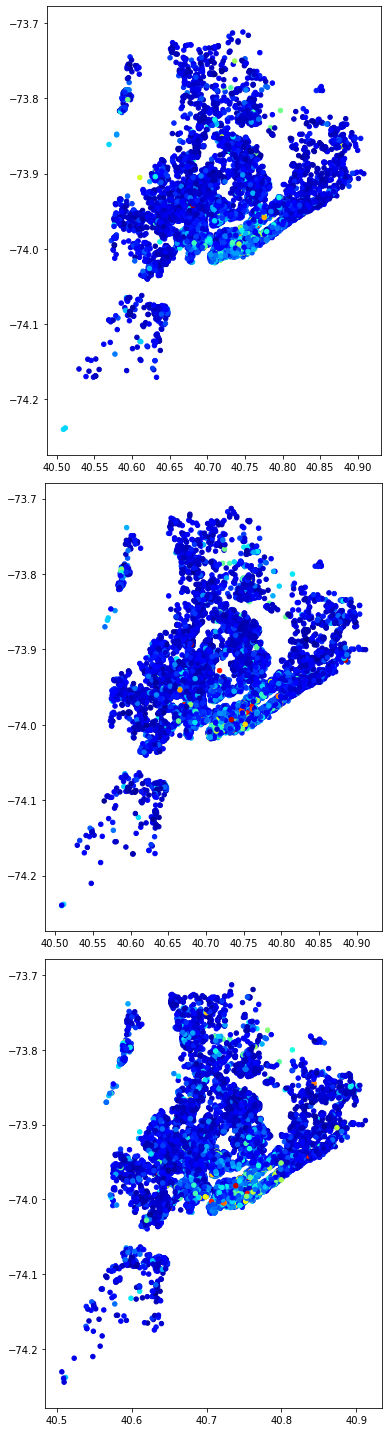

In [15]:
fig, axs = plt.subplots(3, figsize=(20, 20))
data = [fullData[fullData['date'] == "2019-08-06"], fullData[fullData['date'] == "2018-08-06"],fullData[fullData['date'] == "2017-08-02"]]
axs[0].scatter(data[2]['latitude'], data[2]['longitude'], c=data[2]['price'],s=20, marker = 'o', cmap = cm.jet);
axs[0].axis('scaled')
axs[1].scatter(data[1]['latitude'], data[1]['longitude'], c=data[1]['price'],s=20, marker = 'o', cmap = cm.jet);
axs[1].axis('scaled')
axs[2].scatter(data[0]['latitude'], data[0]['longitude'], c=data[0]['price'],s=20, marker = 'o', cmap = cm.jet);
axs[2].axis('scaled')
fig.tight_layout()
plt.show()